<H1 align="center">Основы машинного обучения. <br><br>Стратегия удержания клиентов в сети фитнес-центров.</H1><br><br>

**Цель исследования:** 

*Провести анализ и подготовить план действий по удержанию клиентов:*
- *научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;*
- *сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;*
- *проанализировать основные признаки, наиболее сильно влияющие на отток;*
- *сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:*
 - *выделить целевые группы клиентов;*
 - *предложить меры по снижению оттока;*
 - *определить другие особенности взаимодействия с клиентами.*

**Описание данных:**

- Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц:
 - **'Churn'** — факт оттока в текущем месяце;
   - **'Churn' == 1** - ушедшие пользователи;
   - **'Churn' == 0** - оставшиеся пользователи.


- Данные пользователя за предыдущий до проверки факта оттока месяц:
 - **'gender'** — пол;
 - **'Near_Location'** — проживание или работа в районе, где находится фитнес-центр;
 - **'Partner'** — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
 - **'Promo_friends'** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
 - **'Phone'** — наличие контактного телефона;
 - **'Age'** — возраст;
 - **'Lifetime'** — время с момента первого обращения в фитнес-центр (в месяцах).


- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
 - **'Contract_period'** — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
 - **'Month_to_end_contract'** — срок до окончания текущего действующего абонемента (в месяцах);
 - **'Group_visits'** — факт посещения групповых занятий;
 - **'Avg_class_frequency_total'** — средняя частота посещений в неделю за все время с начала действия абонемента
 - **'Avg_class_frequency_current_month'** — средняя частота посещений в неделю за предыдущий месяц;
 - **'Avg_additional_charges_total'** — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

**Оглавление:**<br>
    
1 [Загрузим данные.](#num1)
   
2 [Проведём исследовательский анализ данных (EDA).](#num2)
    
   2.1 [Вывод.](#num21)
    
3 [Построим модель прогнозирования оттока пользователей.](#num3)

   3.1 [Вывод.](#num31)
    
4 [Выполним кластеризацию пользователей.](#num4)
    
5 [Общие выводы.](#num5)
        


<a id="num1"></a>
## Загрузим данные.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from IPython.display import display

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score

# визуализация
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# прочтём датафрейм
data = pd.read_csv('gym_churn.csv')
df = data.copy()

In [3]:
pd.set_option('display.max_columns', None) # уберём лимит на изображаемое количество столбцов
pd.set_option('display.max_rows', 100)     # повысим лимит на изображаемое количество строк
pd.set_option('max_colwidth', 110)         # установим максимальную ширину столбца для таблиц

In [4]:
# функции для выделения текста цветом (восьмеричные escape-символы '\ 033')
def colorRB(colorR, colorB): print("\033[1;91m {} \033[0m \033[1;90m {} \033[0m".format(colorR, colorB))
def colorR(colorR): print("\033[1;91m {} \033[0m" .format(colorR))
def colorB(colorB): print("\033[1;98m {} \033[0m" .format(colorB))

<a id="num2"></a>
## Проведём исследовательский анализ данных (EDA).

<font size=3>Напишем функцию для получения основной информации о датафрейме.</font>

In [5]:
def datainfo(data):
    
    """
       функция для получения основной информации о датафрейме, 
       функции передаётся датафрейм
       
    """
    
    # переменные для выделения цветом (восьмеричные escape-символы '\ 033')
    BB = '\033[1;90m'          # Черный, жирный цвет
    BR = '\033[1;91m'          # Красный, жирный цвет
    Clr_Off = '\033[0m'        # Сброс выделения (ставится в конце выделяемой строки)
    
    # приведём названия столбцов к нижнему регистру
    #data.columns = data.columns.str.lower()
    data.columns = data.columns.str.replace(" ", "_").str.lower()
    
    print(BR + '\n\nСтруктура датафрейма:' + Clr_Off, end='\n\n')
    data.info()
    
    print(BR + '\n\nДатафрейм:' + Clr_Off)
    display(data.sample(5).T)
    
    # количество пропущенных значений
    data_full_isna = data.isna()
    if data_full_isna.sum().sum() == 0:
        print(BR + '\n\nОбщее количество пропущенных значений: ' + Clr_Off, BB, data_full_isna.sum().sum(), Clr_Off)
    else:
        # найдём все пропуски в процентном отношении ко всему датафрейму
        print(BR + '\n\nОбщее количество пропущенных значений: ' + Clr_Off, BB, data_full_isna.sum().sum(), Clr_Off)
        print(BR + 'Процент пропущенных значений в колонках: ' + Clr_Off)
        display(data[data_full_isna].sum().astype(str) + '%')
    
    # количество дубликатов
    data_full_duplicated = data.duplicated().sum()
    if data_full_duplicated == 0:
        print(BR + '\n\nОбщее количество дубликатов: ' + Clr_Off, BB, data_full_duplicated, Clr_Off)
    else:
        print(BR + '\n\nОбщее количество дубликатов: ' + Clr_Off, BB, data_full_duplicated, Clr_Off)
        # процент дубликатов
        print(BR + 'Общий процент дубликатов: ' + Clr_Off, BB, '{:.1%}'.format(data_full_duplicated / len(data)), Clr_Off)
        # количество полных дубликатов по колонкам
        print(BR + 'Количество дубликатов в колонках: ' + Clr_Off)
        display(data[data.duplicated()].iloc[:, 0].value_counts())
    
    # количество уникальных значений в датафрейме
    print(BR + '\n\nКоличество уникальных значений в датафрейме:' + Clr_Off)
    display(data.nunique())

In [6]:
datainfo(df)



Структура датафрейма:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total      

,2216,2738,1958,3285,1324
gender,0.000000,0.000000,0.000000,1.000000,0.000000
near_location,1.000000,1.000000,0.000000,1.000000,1.000000
partner,0.000000,0.000000,1.000000,0.000000,1.000000
promo_friends,0.000000,1.000000,0.000000,0.000000,1.000000
phone,1.000000,1.000000,0.000000,1.000000,1.000000
contract_period,1.000000,1.000000,1.000000,1.000000,12.000000
group_visits,0.000000,1.000000,1.000000,0.000000,1.000000
age,30.000000,28.000000,26.000000,26.000000,29.000000
avg_additional_charges_total,177.759353,198.874967,464.068749,114.092768,301.036014
month_to_end_contract,1.000000,1.000000,1.000000,1.000000,11.000000




Общее количество пропущенных значений:   0 


Общее количество дубликатов:   0 


Количество уникальных значений в датафрейме:


gender                                  2
near_location                           2
partner                                 2
promo_friends                           2
phone                                   2
contract_period                         3
group_visits                            2
age                                    23
avg_additional_charges_total         4000
month_to_end_contract                  12
lifetime                               29
avg_class_frequency_total            3913
avg_class_frequency_current_month    3820
churn                                   2
dtype: int64

*Датафрейм состоит из **14** колонок и **4000** строк. Колонки имеют только числовые значения, причём в семи колонках значения принимают бинарный вид. Пропущенных значений и дубликатов не обнаруженно.*

<font size=3>Собирём краткую статистическую сводку для данных, методом describe()</font>

In [7]:
def describe(data):
    
    """
       статистические показатели датафрейма, 
       с помощью менеджера контекста, избавимся 
       от экспоненциальной записи
       
    """
    
    # переменные для выделения текста цветом (восьмеричные escape-символы \ 033)
    BB = '\033[1;90m'          # Черный
    BR = '\033[1;91m'          # Красный
    Clr_Off = '\033[0m'        # Сброс цвета текста (ставится в конце текста)
    
    print(BR + '\n\nСтатистические показатели датафрейма:' + Clr_Off)
    with pd.option_context('display.float_format', '{:.2f}'.format):
        display(data.describe(include='all', datetime_is_numeric=True).T)

In [8]:
describe(df)



Статистические показатели датафрейма:


,count,mean,std,min,25%,50%,75%,max
gender,4000.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.00,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.00,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.00,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.00,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.00,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.00,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.00,4.32,4.19,1.00,1.00,1.00,6.00,12.00


***Статистическое описание датафрейма.***
- *Распределение по полу примерно одинаково*
- *Большинство клиентов (**85%**) живет или работает рядом с фитнес-клубом*
- *Примерно половина клиентов являются сотрудниками партнерских организаций*
- *Около **30%** клиентов пришли по программе "Приведи друга"*
- *Известны мобильные номера примерно **90%** клиентов*
- *Средняя длительность действующего абонемента - **4.7** месяцев*
- *Около **40%** клиентов посещают групповые занятия*
- *Средний возраст клиентов **29** лет (возраст клиентов от **18** до **41** года)*
- *Средняя суммарная выручка от других услуг фитнес-центра* - **147**
- *средняя длительность действующего абонемента - **4.3** месяцев*
- *Среднее время с момента первого обращения в фитнес-центр - **3.7** месяцев*
- *Средняя частота посещений за все время - **1.88** раз в неделю*
- *Средняя частота посещений за последний месяц - **1.77** раз в неделю*
- *Общая доля оттока* - **27%**


*Чем ближе стандартное отклонение к 0, тем правдоподобнее среднее значение (стандартное отклонение близкое к 0, говорит о маленькой вариабельности данных).*

*Наиболее изменчивые данные сосредоточены в колонках:*
- *Длительность действующего абонемента*
- *Возраст*
- *Суммарная выручка от других услуг фитнес-центра*
- *Длительность действующего абонемента*
- *Время с момента первого обращения в фитнес-центр*
- *Частота посещений за последний месяц*

<font size=3>Посмотрим средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.</font>

In [9]:
# средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
display(df.groupby(['churn']).mean().T
        .style.background_gradient(cmap='Blues', axis=1)
       )

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


 *Значения признаков: **'phone'**, **'gender'** примерно одинаково для всех групп и потому не влияют на их разделение на группы.*

<font size=3>Выберем колонки, в которых средние значения признаков в группах (тех, кто остался и тех, кто ушёл) различаются. Построим по ним график распределения признаков.</font>

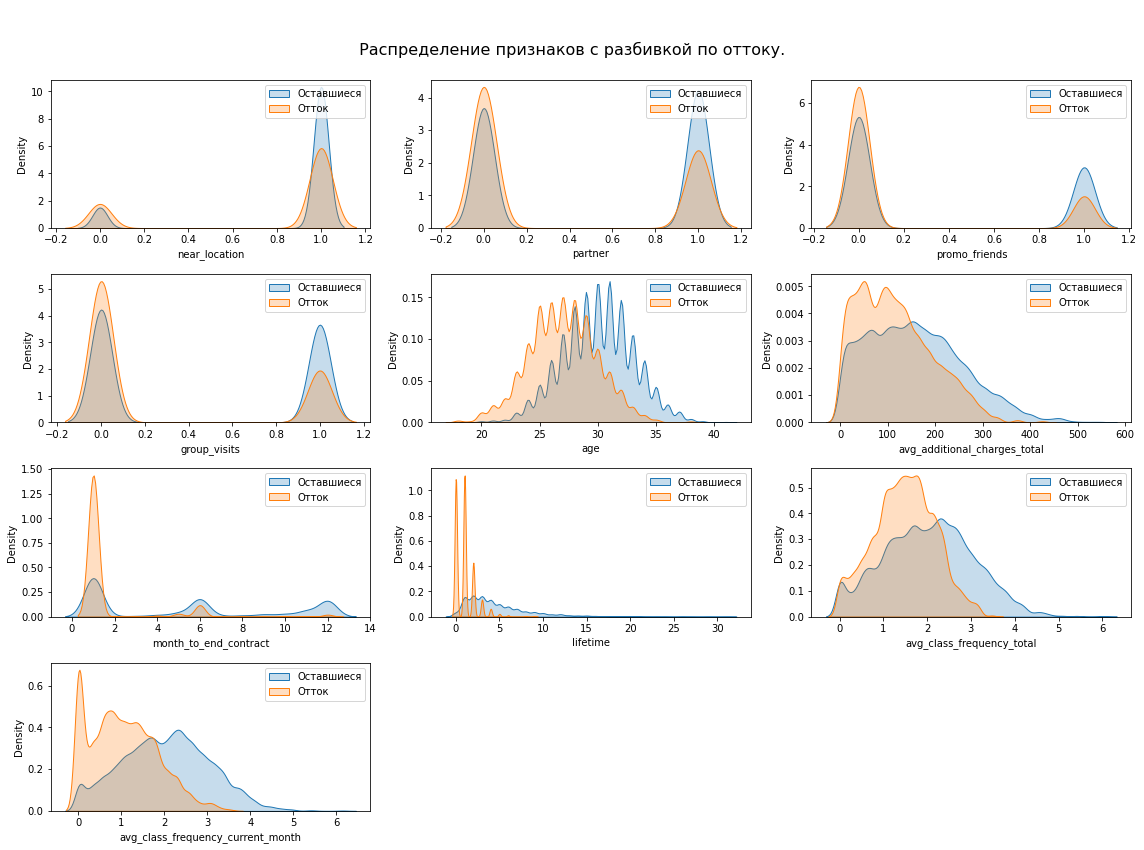

In [10]:
# построим график распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)
column = ['near_location',
          'partner',
          'promo_friends',
          'group_visits',
          'age',
          'avg_additional_charges_total',
          'month_to_end_contract',
          'lifetime',
          'avg_class_frequency_total',
          'avg_class_frequency_current_month',
         ]

plt.figure(figsize=(16, 12))
for i, j in enumerate(column):
    # задаём положение графика в сетке, i + 1 - порядковый номер графика
    ax = plt.subplot(4, 3, i+1)
    for churn in df['churn'].unique():
        current = df.query('churn == @churn')
        sns.kdeplot(current[j], bw_adjust=.5, shade=True)
        plt.legend(['Оставшиеся', 'Отток'])

plt.suptitle('\n\n Распределение признаков с разбивкой по оттоку. \n', fontsize = 16)
plt.tight_layout()

plt.show()

***Признаки свойственные для клиентов попавших в отток и для оставшихся клиентов:***

- *Близко проживающие или работающие клиенты реже уходят в отток*
- *Сотрудники компаний-партнеров реже уходят в отток*
- *Клиенты, пришедшие по акции "Приведи друга" реже уходят в отток*
- *Сотрудники, посещающие групповые занятия, реже уходят в отток*
- *Средний возраст клиентов выше у оставшихся пользователей*
- *Суммарная выручка от других услуг фитнес-центра выше у оставшихся пользователей*
- *Срок до окончания текущего абонемента больше у оставшихся пользователей*
- *Время с момента первого обращения в фитнес-центр больше у оставшихся пользователей*
- *Частота посещений в неделю за предыдущий месяц выше у оставшихся пользователей*

<font size=3>Построим матрицу корреляций и отобразим её.</font>

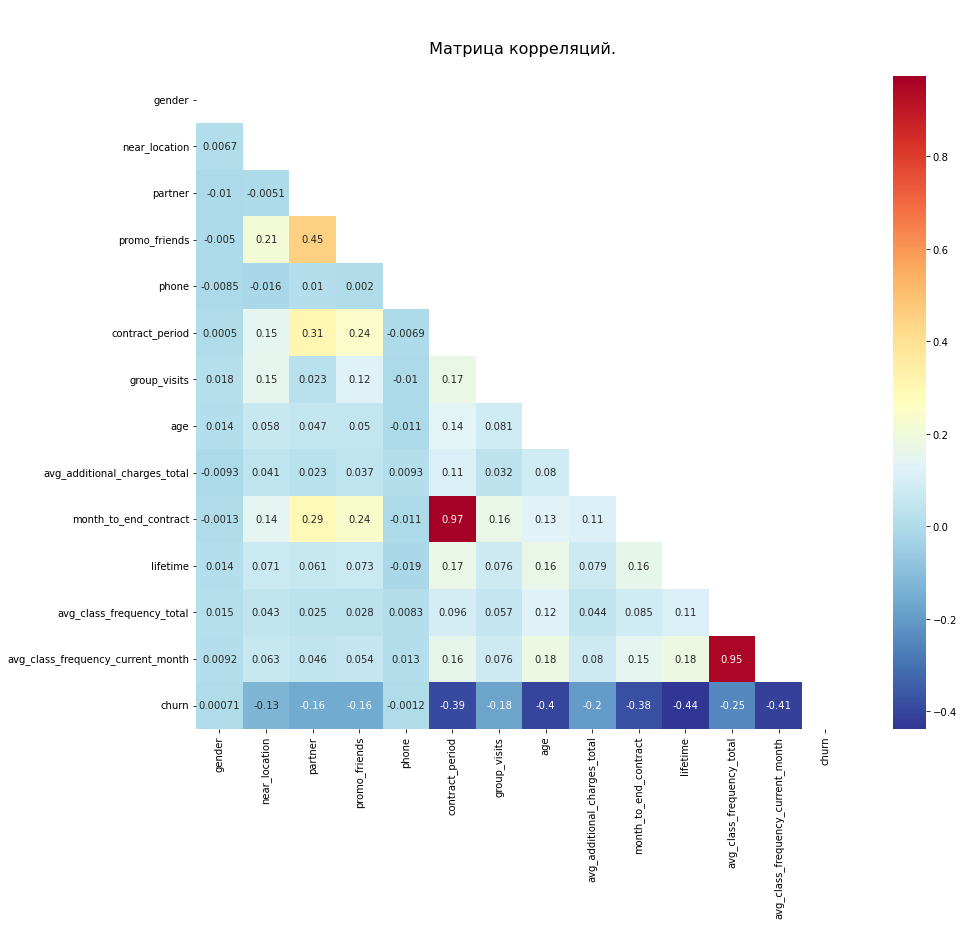

In [11]:
# матрица корреляций
plt.figure(figsize=(16, 12))
matrix = np.triu(df.corr())
ax = sns.heatmap(df.corr(),
                 annot=True,
                 fmt='.2g',
                 square=True,
                 mask=matrix,
                 cmap='RdYlBu_r',
                )
plt.title('\n\n Матрица корреляций. \n', fontsize = 16)

plt.show()

*На матрице корреляций мы видим:*

- *Два мультиколлинеарных признака **'avg_class_frequency_total'** и **'contract_period'** (коэффициент корреляции больше 0,7)*
- *Сильно коррелирующие признаки между собой:*
 - *Между сотрудниками пришедшими по программе "Приведи друга" и сотрудниками компании-партнёра клуба*
- *Для целевой переменной **'churn'** характерна отрицательная корреляция, сильную корреляцию мы наблюдаем с:*
 - *Длительностью действующего абонемента*
 - *Возрастом*
 - *Сроком до окончания действующего абонемента*
 - *Временем с момента первого обращения в фитнес-центр*
 - *Средней частотой посещений в неделю за предыдущий месяц*

***Мультиколлинеарность*** — *корреляция независимых переменных, которая затрудняет оценку и анализ общего результата она может стать причиной переобучаемости модели, что приведет к неверному результату.*
*Чтобы избавиться от мультиколлинарности, необходимо исключить из модели один из коррелирующих факторов.*

<font size=3>Уберём из датафрейма два мультиколлинеарных признака, это колонки: 'avg_class_frequency_total' и 'contract_period'.</font>

In [12]:
# уберём из датафрейма коррелирующие колонки 'avg_class_frequency_total' и 'contract_period' методом drop()
df = df.drop(['avg_class_frequency_total', 'contract_period'], axis = 1)

display(df.head().T)

,0,1,2,3,4
gender,1.00000,0.000000,0.000000,0.000000,1.000000
near_location,1.00000,1.000000,1.000000,1.000000,1.000000
partner,1.00000,0.000000,1.000000,1.000000,1.000000
promo_friends,1.00000,0.000000,0.000000,1.000000,1.000000
phone,0.00000,1.000000,1.000000,1.000000,1.000000
group_visits,1.00000,1.000000,0.000000,1.000000,0.000000
age,29.00000,31.000000,28.000000,33.000000,26.000000
avg_additional_charges_total,14.22747,113.202938,129.448479,62.669863,198.362265
month_to_end_contract,5.00000,12.000000,1.000000,12.000000,1.000000
lifetime,3.00000,7.000000,2.000000,2.000000,3.000000


<a id="num21"></a>
### Вывод.

*Мы провели исследовательский анализ данных, убрали Мультиколлинеарные признаки и подготовили данные для машинного обучения.*

<a id="num3"></a>
## Построим модель прогнозирования оттока пользователей.

<br><font size=3>Вычислим метрику логистической регрессии.</font>

Чтобы не удалять вручную скоррелированные признаки, применим L1-регуляризацию (Lasso-регрессию). То есть минимизируем ошибку подбором оптимальных весов, дополнительно стараемся ещё и минимизировать сумму модулей этих весов.

In [13]:
from sklearn.linear_model import Lasso

# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# стандартизируем данные методом StandartScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для нашей модели, Lasso(alpha=1.0) — величина регуляризации (по-умолчанию)
model = Lasso()

# обучим модель
model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test_st)

# создадим датафрейм с признаками и их весами
features = pd.DataFrame({'feature': X.columns, 'coeff': model.coef_}) # воспользуйтесь методом coef_
features['coeff_abs'] = features['coeff'].abs()

# выведим упорядоченный по модулю коэффициентов датафрейм с признаками
display(features.sort_values(by='coeff_abs', ascending=False))

,feature,coeff,coeff_abs
0,gender,0.0,0.0
1,near_location,-0.0,0.0
2,partner,-0.0,0.0
3,promo_friends,-0.0,0.0
4,phone,-0.0,0.0
5,group_visits,-0.0,0.0
6,age,-0.0,0.0
7,avg_additional_charges_total,-0.0,0.0
8,month_to_end_contract,-0.0,0.0
9,lifetime,-0.0,0.0


In [14]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']

# разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# стандартизируем данные методом StandartScaler
scaler = StandardScaler()              # создадим объект класса StandardScaler
scaler.fit(X_train)                    # применим его к обучающей выборке
X_train_st = scaler.transform(X_train) # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_test_st = scaler.transform(X_test)   # стандартизацию к матрице признаков для тестовой выборки

In [15]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)

# обучим модель логистической регрессии
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

# оценим метрики accuracy, precision и recall на валидационной выборке выведем все изученные метрики
colorR('\nМетрики логистической регрессии: \n')
colorRB('Accuracy: ', '{:.2f}'.format(accuracy_score(y_test, lr_predictions)))
colorRB('Precision:', '{:.2f}'.format(precision_score(y_test, lr_predictions)))
colorRB('Recall:   ', '{:.2f}'.format(recall_score(y_test, lr_predictions)))

 
Метрики логистической регрессии: 
 
 Accuracy:    0.91 
 Precision:   0.84 
 Recall:      0.83 


<br><font size=3>Вычислим метрику алгоритма случайного леса.</font>

In [16]:
# зададим алгоритм для модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)

# обучите модель случайного леса
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

# оценим метрики accuracy, precision и recall на валидационной выборке, выведем все изученные метрики
colorR('\nМетрики алгоритма случайного леса: \n')
colorRB('Accuracy: ', '{:.2f}'.format(accuracy_score(y_test, rf_predictions)))
colorRB('Precision:', '{:.2f}'.format(precision_score(y_test, rf_predictions)))
colorRB('Recall:   ', '{:.2f}'.format(recall_score(y_test, rf_predictions)))

 
Метрики алгоритма случайного леса: 
 
 Accuracy:    0.91 
 Precision:   0.85 
 Recall:      0.80 


<br><font size=3>Определим коэффициенты признаков для модели логистической регрессии.</font>

In [17]:
# найдём коэффициенты признаков для модели логистической регрессии
features = pd.DataFrame(lr_model.coef_.T, X.columns).reset_index()
features.columns = ['feature', 'coef']
features['coef'] = features['coef'].apply(lambda x: abs(x))

colorR('\n\nКоэффициенты признаков для модели логистической регрессии:')
display(features)

 

Коэффициенты признаков для модели логистической регрессии: 


,feature,coef
0,gender,0.021272
1,near_location,0.066987
2,partner,0.067407
3,promo_friends,0.143751
4,phone,0.076467
5,group_visits,0.386240
6,age,1.183315
7,avg_additional_charges_total,0.576592
8,month_to_end_contract,1.395119
9,lifetime,3.655744


<a id="num31"></a>
### Вывод.

**'Accuracy'** - доля правильных ответов алгоритма.<br>
**'Precision'** (точность) - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными.<br>
**'Recall'** (полнота) - показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.<br>


- *Точность метрики случайного леса оказалась чуть выше при низкой полноте.*
- *По совокупности полноты и точности, **метрика логистической регрессии опережает метрику случайного леса**.*
- *Определили коэффициенты признаков для модели логистической регрессии с помощью которых мы можем делать прогнозы для новых выборок.*

<a id="num4"></a>
## Выполним кластеризацию пользователей.

In [18]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']

# обязательная стандартизация данных перед работой с алгоритмами
scaler = StandardScaler()        # создаём объект класса scaler (нормализатор)
X_sc = scaler.fit_transform(X)   # обучаем нормализатор и преобразуем набор данных

# построим матрицу расстояний на стандартизованной матрице признаков
linked = linkage(X_sc, method = 'ward') 

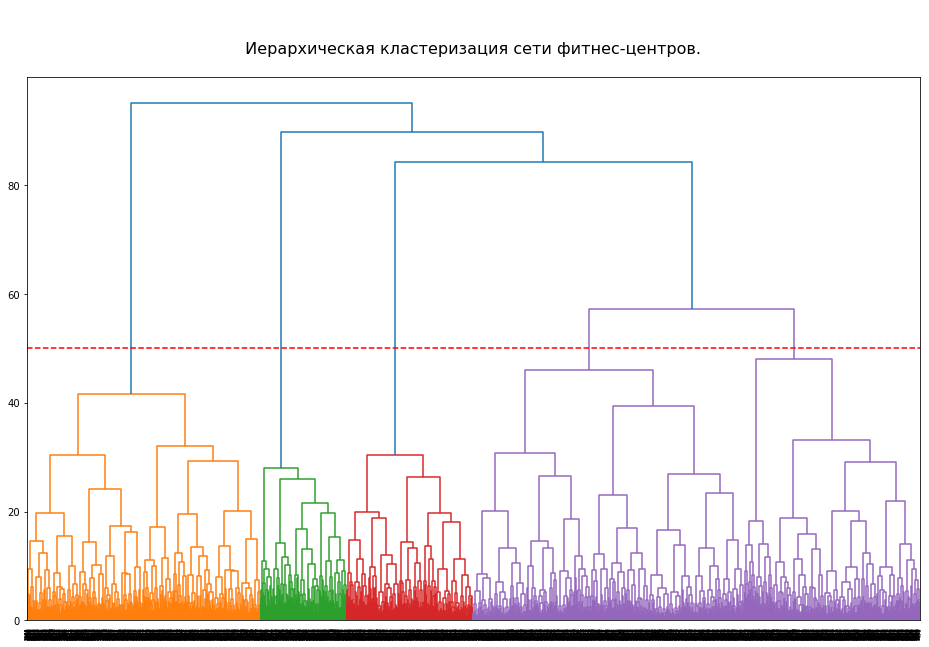

In [19]:
# нарисуем дендрограмму
plt.figure(figsize=(16, 10))  
dendrogram(linked, orientation='top')
plt.axhline(y=50, color='r', linestyle='--')
plt.title('\n\n Иерархическая кластеризация сети фитнес-центров. \n', fontsize = 16)

plt.show() 

*Если мы нарисуем горизонтальную линию, которая проходит через самое длинное расстояние (ниже горизонтальной линии соединяющей кластеры), мы получим 5 кластеров.*

<br><font size=3>Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.</font>

In [20]:
# обязательная стандартизация данных перед работой с алгоритмами
scaler = StandardScaler()                  # создадим объект класса scaler (нормализатор)
X_sc = scaler.fit_transform(X)             # обучим нормализатор и преобразуем набор данных

# зададим число кластеров, равное 5, и зафиксируем значение 'random_state' для воспроизводимости результата
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)              # применим алгоритм K-Means к данным и сформируем вектор кластеров
df['cluster_km'] = labels                  # сохраним метки кластера в поле нашего датасета

<br><font size=3>Посчитаем метрику силуэта для нашей кластеризации.</font>

In [21]:
# посчитаем метрику силуэта для нашей кластеризации
colorRB('Silhouette_score:', '{:.2f}'.format(silhouette_score(X_sc, labels)))

 Silhouette_score:   0.12 


***«Метрика силуэта»*** *показывает, насколько объект своего кластера похож на свой кластер больше, чем на чужой. 
Чем ближе значение к 1, тем качественнее кластеризация:*
- *Лучшее значение: **1**;*
- *Значение около **0** (указывает на перекрытие кластеров);*
- *Худшее: **-1** (указывает на то,что выборка была назначена не тому кластеру).*

*Значение метрики **0.12** не очень высокое, что может указывать на перекрытие кластеров.*

<font size=3>Для каждого полученного кластера посчитаем средние значения признаков.<br>
Исходя из средних значений признаков, составим портреты пользователей для каждого кластера.</font>

In [22]:
# статистика по средним значениям признаков по кластерам
display(df.groupby('cluster_km').mean().T)

cluster_km,0,1,2,3,4
gender,0.492000,0.495352,0.511194,0.502455,0.550481
near_location,0.994000,0.998672,1.000000,0.000000,0.998798
partner,0.953000,0.378486,0.226368,0.489362,0.274038
promo_friends,1.000000,0.046481,0.114428,0.072013,0.075721
phone,0.906000,0.903054,0.899254,0.913257,0.897837
group_visits,0.528000,0.000000,0.182836,0.232406,1.000000
age,29.633000,30.342629,26.807214,28.700491,30.248798
avg_additional_charges_total,154.086252,174.392898,111.073289,137.375245,155.206260
month_to_end_contract,6.730000,4.698539,1.715174,2.826514,4.707933
lifetime,4.287000,5.166003,1.420398,3.027823,4.483173


**Типичные портреты пользователей.**


- **Кластер 0:**
 - *Отток - 10.8%*
 - *Живут или работают недалеко от фитнес-центра*
 - *Сотрудник компании-партнёра клуба - 95%*
 - *Использовали промо-код от знакомого при оплате первого абонемента - 100%*
 - *Групповые занятия посещали - 53%*
 - *Срок до окончания абонемента - около 7 месяцев*
 - *Время с момента первого обращения в фитнес-центр - 4 месяца*
 - *Частота посещений за предыдущий месяц - 1.9 раза в неделю*
 
 
- **Кластер 1:**
 - *Отток - 4.6% (**самый низкий**)*
 - *Живут или работают недалеко от фитнес-центра*
 - *Сотрудник компании-партнёра клуба - 38%*
 - *Использовали промо-код от знакомого при оплате первого абонемента - 4.6%*
 - *Групповые занятия посещали - 0%*
 - *Срок до окончания абонемента - около 5 месяцев*
 - *Время с момента первого обращения в фитнес-центр - 5 месяцев*
 - *Частота посещений за предыдущий месяц - **2.2** раза в неделю (чаще всего)*


- **Кластер 2:**
 - *Отток - 74% (**самый высокий**)*
 - *Средний возраст **26** лет*
 - *Живут или работают недалеко от фитнес-центра*
 - *Сотрудник компании-партнёра клуба - 23%*
 - *Использовали промо-код от знакомого при оплате первого абонемента - 11.4%*
 - *Групповые занятия посещали - 18%*
 - *Срок до окончания абонемента - через **1.7** месяца*
 - *Время с момента первого обращения в фитнес-центр - **1.4** месяца*
 - *Частота посещений за предыдущий месяц - **0.97** раза в неделю (реже всего)*


- **Кластер 3:**
 - *Отток - 40%*
 - *Живут или работают **ДАЛЕКО** от фитнес-центра*
 - *Сотрудник компании-партнёра клуба - 49%*
 - *Использовали промо-код от знакомого при оплате первого абонемента - 7%*
 - *Групповые занятия посещали - 23%*
 - *Срок до окончания абонемента - через 2.8 месяца*
 - *Время с момента первого обращения в фитнес-центр - 3 месяца*
 - *Частота посещений за предыдущий месяц - **1.6** раза в неделю*


- **Кластер 4:**
 - *Отток - 9.2%*
 - *Живут или работают недалеко от фитнес-центра*
 - *Сотрудник компании-партнёра клуба - 27%*
 - *Использовали промо-код от знакомого при оплате первого абонемента - 7.5%*
 - *Групповые занятия посещали - 100%*
 - *Срок до окончания абонемента - около 4.7 месяцев*
 - *Время с момента первого обращения в фитнес-центр - 4.5 месяцев*
 - *Частота посещений за предыдущий месяц - 2 раза в неделю*
 
 *Признаки: **'phone'**, **'gender'** не влияют на разделение на кластеры, так как их значения примерно одинаковы для всех кластеров.*

<br><font size=3>Для каждого кластера построим диаграмму распределения признаков.</font>

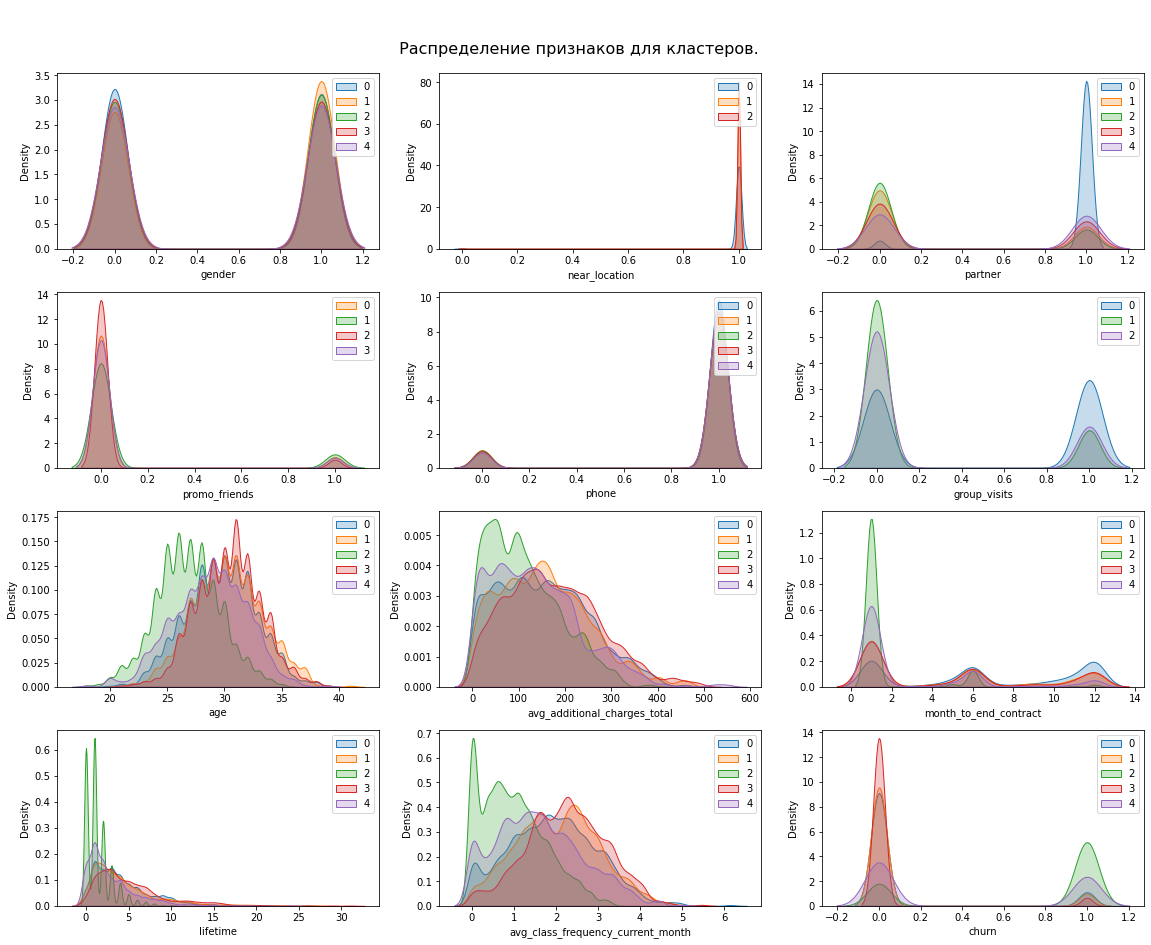

In [23]:
# построим распределения признаков для кластеров
col_pairs = df.columns.drop(['cluster_km'])

plt.figure(figsize=(16,16))
for i, j in enumerate(col_pairs):
    # задаём положение графика в сетке, i + 1 - порядковый номер графика
    plt.subplot(5, 3, i+1)
    for cluster in df['cluster_km'].unique():
        sns.kdeplot(df[df['cluster_km'] == cluster][j],
                    label=cluster,
                    bw_adjust=.5,
                    shade=True,
                    warn_singular=False,
                   )
        plt.legend(['0', '1', '2', '3', '4'])
        
plt.suptitle('\n\n Распределение признаков для кластеров. \n', fontsize = 16)
plt.tight_layout()

plt.show()

<br>*Пользователи выполнили целевое действие – значение **1** в бинаных колонках, кроме колонки 'churn'*
<br>*Пользователи не выполнили целевое действие – значение **0** в бинаных колонках, кроме колонки 'churn'*
<br><br>
*Судя по диаграммам распределения, в отток уходят чаще:*
- *Пользователи живущие или работающие **ДАЛЕКО** от фитнес-центра*
- *Пользователи не являюшиеся сотрудниками компании-партнёра клуба*
- *Наличие контактного телефона **СЛАБО** влияет на отток*
- *Пользователи которые не использовали промо-код от знакомого при оплате первого абонемента*
- *Пользователи, средний возраст которых составляет **26** лет*
- *Пользователи с низкими тратами на другие услуги фитнес-центра*
- *Пользователи которые не посещали групповые занятия*
- *Пользователи у которых срок до окончания действующего абонемента составляет **1** месяц*
- *Самый большой отток происходит в первые **5** дней (с момента первого обращения в фитнес-центр)*
- *Пользователи имеющие низкую частоту посещений в неделю*
<br><br>

*Признаки не влияющие на отток(имеют примерно одинаковое распределение):*
- *Пол*

<br><font size=3>Для каждого кластера посчитаем долю оттока.</font>

In [24]:
# для каждого полученного кластера посчитаем долю оттока методом groupby()
display(df.groupby(['cluster_km'])['churn'].apply(lambda x: x.groupby(x).size()/len(x)*100).round(2).unstack())

,0,1
cluster_km,,
0,89.20,10.80
1,95.35,4.65
2,25.87,74.13
3,59.90,40.10
4,90.75,9.25


*Все кластеры отличаются по доле оттока, самые низкие доли оттока у кластеров:*
- **1 – 4.65%**
- **4 – 9.25%**
- **0 – 10.80%**

*Кластеры склонные к оттоку:*
- **2 – 74.13%**
- **3 – 40.10%**

<a id="num5"></a>
## Общие выводы.

*Проведя исследовательский анализ данных, мы построили две модели прогнозирования оттока: логистической регрессии и случайного леса. 
<br>Из двух моделей, мы выбрали метрику логистической регрессии и определили зависимости между зависимой и независимой переменными. Определили коэффициенты признаков для модели логистической регрессии. 
<br>Выполнили кластеризацию пользователей на **5** кластеров (кластеры перекрываются друг с другом). 
<br>Составили типичные портреты пользователей для каждого кластера и определили кластеры склонные к оттоку (кластеры **2** и **3**).*
<br><br>*Определили типичные признаки пользователей уходящих в отток:*
- *Пользователи живущие или работающие **ДАЛЕКО** от фитнес-центра*
- *Пользователи не являюшиеся сотрудниками компании-партнёра клуба*
- *Пользователи которые не использовали промо-код от знакомого при оплате первого абонемента*
- *Пользователи, средний возраст которых составляет **26** лет*
- *Пользователи с низкими тратами на другие услуги фитнес-центра*
- *Пользователи которые не посещали групповые занятия*
- *Пользователи у которых срок до окончания действующего абонемента составляет **1** месяц*
- *Самый большой отток происходит в первые **5** дней (с момента первого обращения в фитнес-центр)*
- *Пользователи имеющие низкую частоту посещений в неделю*

<i>**Рекомендации по результатам исследования:**</i>
- *Для ДАЛЕКО живущих пользователей можно организовать трансфер до фитнес-центра, удобный график работы*
- *Молодым пользовамелям (средний возраст 26 лет) подойдёт отдельный зал для занятий или раздельное время занятий между пользователями разных возрастных категорий (непонятна причина их оттока, возможно из-за стеснительности. Чтобы точнее определить причины оттока молодых пользователей, нужно провести как минимум опрос среди них)*
- *Более широко использовать промоакции: «приведи друга», на первую покупку в фитнес-центре*
- *Абонемент сделать минимум на **6** месяцев*
- *Стимулировать посещаемость фитнес-центра (например организовать сауну, бесплатные напитки)*
- *Стимулировать траты на другие услуги фитнес-центра, например организовать магазин спортивного питания, «диетическое кафе» для спортсменов.*